In [1]:
import pandas as pd
import numpy as np
import ijson
import time
import networkx as nx
import pickle
import random
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1. Data 

## Converting json data into a data frame

In [3]:
PAPERS = []

json_file_path = r'archive/file.json'

# Creating a DataFrame to store the extracted information
columns = ['id', 'title', 'year', 'n_citation', 'doc_type', 'publisher', 'references', 'doi',
           'num_authors', 'author_names', 'author_ids', 'author_universities']




start = time.process_time()
with open(json_file_path, 'rb') as f:
    for i, element in enumerate(ijson.items(f, 'item')):
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']

        year = element.get('year')
        if year:
            paper['year'] = year
        else:
            paper['year'] = np.nan

        n_citation = element.get('n_citation')
        if n_citation:
            paper['n_citation'] = n_citation
        else:
            paper['n_citation'] = 0

        doc_type = element.get('doc_type')
        if doc_type:
            paper['doc_type'] = doc_type
        else:
            paper['doc_type'] = np.nan

        publisher = element.get('publisher')
        if publisher:
            paper['publisher'] = publisher
        else:
            paper['publisher'] = np.nan

        references = element.get('references')
        if references:
            paper['reference_count'] = len(references)
            # joining all refs id in a `;` separated string
            paper['references'] = ';'.join([str(int(r)) for r in references])
        else:
            paper['reference_count'] = np.nan
            paper['references'] = np.nan

        doi = element.get('doi')
        if doi:
            paper['doi'] = f"https://doi.org/{element['doi']}"
        else:
            paper['doi'] = np.nan

        # Extracting author information
        authors = element.get('authors', [])
        paper['num_authors'] = len(authors)
        #paper['author_names'] = [author['name'] for author in authors]
        paper['author_ids'] = [author.get('id' , None ) for author in authors]
        paper['author_universities'] = [author.get('org' , None) for author in authors]

        PAPERS.append(paper)
        

        if i % 48000 == 0:
            print(f"{i}:{round((time.process_time() - start), 2)}s ", end="")
            # break


0:0.06s 48000:9.25s 96000:17.2s 144000:26.02s 192000:34.41s 240000:44.16s 288000:57.89s 336000:75.0s 384000:87.86s 432000:98.39s 480000:107.5s 528000:121.8s 576000:149.73s 624000:162.06s 672000:179.2s 720000:190.25s 768000:201.72s 816000:213.38s 864000:220.2s 912000:231.59s 960000:242.7s 1008000:253.25s 1056000:265.77s 1104000:274.0s 1152000:281.78s 1200000:287.84s 1248000:298.47s 1296000:306.92s 1344000:313.5s 1392000:318.64s 1440000:325.27s 1488000:335.7s 1536000:340.3s 1584000:345.25s 1632000:350.83s 1680000:358.55s 1728000:361.73s 1776000:365.55s 1824000:369.81s 1872000:374.62s 1920000:377.98s 1968000:382.69s 2016000:387.77s 2064000:391.12s 2112000:395.47s 2160000:399.11s 2208000:403.77s 2256000:407.56s 2304000:439.88s 2352000:443.06s 2400000:453.12s 2448000:456.41s 2496000:465.97s 2544000:469.31s 2592000:471.42s 2640000:498.23s 2688000:504.06s 2736000:530.45s 2784000:534.61s 2832000:564.47s 2880000:568.47s 2928000:571.98s 2976000:602.83s 3024000:607.64s 3072000:611.34s 3120000:641

In [4]:
data = pd.DataFrame(PAPERS)

data.head()

In [ ]:
data.dtypes

id                       int64
title                   object
year                   float64
n_citation               int64
doc_type                object
publisher               object
reference_count        float64
references              object
doi                     object
num_authors              int64
author_ids              object
author_universities     object
dtype: object

In [ ]:
data.describe()

,id,year,n_citation,reference_count,num_authors
count,4.894081e+06,4.894072e+06,4.894081e+06,3.777107e+06,4.894081e+06
mean,2.122643e+09,2.009149e+03,1.680113e+01,1.206324e+01,3.051615e+00
std,6.532389e+08,8.937085e+00,1.158175e+02,1.214674e+01,1.870559e+00
min,1.091000e+03,1.800000e+03,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.996668e+09,2.005000e+03,0.000000e+00,4.000000e+00,2.000000e+00
50%,2.115706e+09,2.011000e+03,3.000000e+00,9.000000e+00,3.000000e+00
75%,2.561952e+09,2.016000e+03,1.100000e+01,1.600000e+01,4.000000e+00
max,3.009038e+09,2.020000e+03,4.832700e+04,1.812000e+03,3.980000e+02


## Data pre-processing

In [ ]:
top_10000_ids = data.groupby('id')['n_citation'].sum().sort_values(ascending=False).head(10000).index

# Filter the original DataFrame based on the top 10000 ids
top_10000_data = data[data['id'].isin(top_10000_ids)]

In [ ]:
top_10000_data

,id,title,year,n_citation,doc_type,publisher,reference_count,references,doi,num_authors,author_ids,author_universities
929,852874,A Spatial Logic based on Regions and Connection.,1992.0,1709,Conference,NaN,NaN,NaN,NaN,3,"[2776268300, 2114878774, 2149556533]","[None, None, None]"
1910,1699105,Algebraic attacks on stream ciphers with linea...,2003.0,758,Conference,Springer Verlag,31.0,17553438;29630963;149636774;1488905225;1512363...,https://doi.org/10.1007/978-3-540-45146-4_11,2,"[342533692, 2125800030]","[Cryptography Research, Schlumberger Smart Car..."
2397,2169610,Support vector machines for multi-class patter...,1999.0,643,Conference,NaN,NaN,NaN,NaN,2,"[2058584252, 2122006335]","[None, None]"
4653,4214443,Systematic mapping studies in software enginee...,2008.0,1032,Conference,BCS Learning & Development Ltd.,15.0,1965321492;2082372845;2103944702;2104789242;21...,https://doi.org/10.14236/ewic/ease2008.8,4,"[2168426453, 2034354864, 2018570109, 2158136113]","[School of Engineering, Blekinge Institute of ..."
4953,4508078,A framework and graphical development environm...,2002.0,1470,Conference,NaN,NaN,NaN,NaN,4,"[2073298952, 2115813747, 7476036, 2090604848]","[None, None, None, None]"
...,...,...,...,...,...,...,...,...,...,...,...,...
4881394,55768394,Mining Multi-label Data,2009.0,858,NaN,"Springer, Boston, MA",70.0,41198089;66588809;216283022;307400639;14884404...,https://doi.org/10.1007/978-0-387-09823-4_34,3,"[2012164496, 1921192703, 695239088]",[Aristotle University of Thessaloniki > > > ...
4881988,5731987,"Original Contribution: Principal components, m...",1992.0,712,Journal,Elsevier Science Ltd.,10.0,1968935533;1980793158;2002554627;2023963201;20...,https://doi.org/10.1016/S0893-6080(05)80089-9,1,[1828928408],[Lappeenranta University of Technology Finland]
4882982,594463866,Graphs on Surfaces,2001.0,831,Book,NaN,NaN,NaN,NaN,2,"[2110954754, 1943902152]","[None, None]"
4884722,631335369,Stochastic Geometry for Wireless Networks,2012.0,1102,Book,NaN,NaN,NaN,NaN,1,[1983969181],"[University of Notre Dame , Indiana]"


In [ ]:
#top_10000_data.to_csv('top_10000_data.csv')

In [4]:
top_10000_data = pd.read_csv('top_10000_data.csv')
top_10000_data = top_10000_data.drop(['Unnamed: 0'], axis=1)
top_10000_data

,id,title,year,n_citation,doc_type,publisher,reference_count,references,doi,num_authors,author_ids,author_universities
0,852874,A Spatial Logic based on Regions and Connection.,1992.0,1709,Conference,NaN,NaN,NaN,NaN,3,"[2776268300, 2114878774, 2149556533]","[None, None, None]"
1,1699105,Algebraic attacks on stream ciphers with linea...,2003.0,758,Conference,Springer Verlag,31.0,17553438;29630963;149636774;1488905225;1512363...,https://doi.org/10.1007/978-3-540-45146-4_11,2,"[342533692, 2125800030]","['Cryptography Research, Schlumberger Smart Ca..."
2,2169610,Support vector machines for multi-class patter...,1999.0,643,Conference,NaN,NaN,NaN,NaN,2,"[2058584252, 2122006335]","[None, None]"
3,4214443,Systematic mapping studies in software enginee...,2008.0,1032,Conference,BCS Learning & Development Ltd.,15.0,1965321492;2082372845;2103944702;2104789242;21...,https://doi.org/10.14236/ewic/ease2008.8,4,"[2168426453, 2034354864, 2018570109, 2158136113]","['School of Engineering, Blekinge Institute of..."
4,4508078,A framework and graphical development environm...,2002.0,1470,Conference,NaN,NaN,NaN,NaN,4,"[2073298952, 2115813747, 7476036, 2090604848]","[None, None, None, None]"
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,55768394,Mining Multi-label Data,2009.0,858,NaN,"Springer, Boston, MA",70.0,41198089;66588809;216283022;307400639;14884404...,https://doi.org/10.1007/978-0-387-09823-4_34,3,"[2012164496, 1921192703, 695239088]",['Aristotle University of Thessaloniki > > >...
9996,5731987,"Original Contribution: Principal components, m...",1992.0,712,Journal,Elsevier Science Ltd.,10.0,1968935533;1980793158;2002554627;2023963201;20...,https://doi.org/10.1016/S0893-6080(05)80089-9,1,[1828928408],['Lappeenranta University of Technology Finland']
9997,594463866,Graphs on Surfaces,2001.0,831,Book,NaN,NaN,NaN,NaN,2,"[2110954754, 1943902152]","[None, None]"
9998,631335369,Stochastic Geometry for Wireless Networks,2012.0,1102,Book,NaN,NaN,NaN,NaN,1,[1983969181],"['University of Notre Dame , Indiana']"


In [5]:
top_10000_data['references'] = top_10000_data['references'].fillna('')
top_10000_data['references'] = top_10000_data['references'].apply(lambda x: x.split(';'))
top_10000_data.head()

,id,title,year,n_citation,doc_type,publisher,reference_count,references,doi,num_authors,author_ids,author_universities
0,852874,A Spatial Logic based on Regions and Connection.,1992.0,1709,Conference,NaN,NaN,[],NaN,3,"[2776268300, 2114878774, 2149556533]","[None, None, None]"
1,1699105,Algebraic attacks on stream ciphers with linea...,2003.0,758,Conference,Springer Verlag,31.0,"[17553438, 29630963, 149636774, 1488905225, 15...",https://doi.org/10.1007/978-3-540-45146-4_11,2,"[342533692, 2125800030]","['Cryptography Research, Schlumberger Smart Ca..."
2,2169610,Support vector machines for multi-class patter...,1999.0,643,Conference,NaN,NaN,[],NaN,2,"[2058584252, 2122006335]","[None, None]"
3,4214443,Systematic mapping studies in software enginee...,2008.0,1032,Conference,BCS Learning & Development Ltd.,15.0,"[1965321492, 2082372845, 2103944702, 210478924...",https://doi.org/10.14236/ewic/ease2008.8,4,"[2168426453, 2034354864, 2018570109, 2158136113]","['School of Engineering, Blekinge Institute of..."
4,4508078,A framework and graphical development environm...,2002.0,1470,Conference,NaN,NaN,[],NaN,4,"[2073298952, 2115813747, 7476036, 2090604848]","[None, None, None, None]"


In [6]:
top_10000_data.sort_values('n_citation', ascending=False).head(5)

,id,title,year,n_citation,doc_type,publisher,reference_count,references,doi,num_authors,author_ids,author_universities
9593,2041404167,The Mathematical Theory of Communication,1949.0,48327,Book,NaN,NaN,[],NaN,1,[2247248564],['External Organizations']
9381,1639032689,"Genetic algorithms in search, optimization, an...",1989.0,44175,Book,NaN,NaN,[],NaN,1,[2102678951],[None]
9008,2912565176,Fuzzy sets,1996.0,42437,NaN,NaN,NaN,[],NaN,1,[2252586558],[None]
8525,2151103935,Distinctive Image Features from Scale-Invarian...,2004.0,35541,Journal,Kluwer Academic Publishers,33.0,"[19720318, 1541642243, 1560959218, 1676552347,...",https://doi.org/10.1023/B:VISI.0000029664.9961...,1,[2104328312],"['Computer Science Department, University of B..."
9000,2911964244,Random Forests,2001.0,34741,NaN,NaN,11.0,"[1507255258, 1580948147, 1605688901, 197584664...",https://doi.org/10.1023/A:1010933404324,1,[2569376642],"['Statistics Department, University of Califor..."


## Creating Citation Grapth  and adding nodes and edges 

Citation graph: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

In [7]:
# Create a directed graph from the top 10000 papers
G_citation = nx.DiGraph()

for i, row in top_10000_data.iterrows():
    G_citation.add_node(row['id'])

    # Add an edge for each reference
    for ref in row['references']:
        # Check if there is a reference
        if ref != '':
            G_citation.add_edge(row['id'] , int(ref))

In [8]:
G_citation.is_directed()

True

In [9]:
list(G_citation.edges)[0:10]

[(1699105, 17553438),
 (1699105, 29630963),
 (1699105, 149636774),
 (1699105, 1488905225),
 (1699105, 1512363553),
 (1699105, 1520563459),
 (1699105, 1542020576),
 (1699105, 1548516269),
 (1699105, 1572961947),
 (1699105, 1573095851)]

In [10]:
list(G_citation.successors(852874))

[]

In [11]:
G_citation.out_degree(852874)

0

In [12]:
list(G_citation.successors(1699105))[0:10]

[17553438,
 29630963,
 149636774,
 1488905225,
 1512363553,
 1520563459,
 1542020576,
 1548516269,
 1572961947,
 1573095851]

In [13]:
G_citation.out_degree(1699105)

31

## Creating Collaboration Grapth  and adding nodes and edges 

Collaboration graph: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

In [17]:
top_10000_data['author_ids'] = top_10000_data['author_ids'].apply(lambda x: x.strip('[]').split(', '))

In [18]:
# Initialize graph and coauthor dict
G_collaboration = nx.Graph()
coauthor_count = {}    # count the number of two authors write together a paper for weighting grapth 

# Iterate through paper rows
for index, row in top_10000_data.iterrows():    

  # Get author ids for this paper
    author_ids = row['author_ids']      

  # Add unique authors as nodes
    for author in author_ids:
        if author not in G_collaboration.nodes():  
            G_collaboration.add_node(author)     #### adding nodes to collaboration grapth which is authors

  # Add edges for author pairs
    for i in range(len(author_ids)):
        for j in range(i+1, len(author_ids)):
      
            id1 = author_ids[i]
            id2 = author_ids[j]
      
            # Add edge
            G_collaboration.add_edge(id1, id2)     #### adding edge to grapth which is collaboration of each two authors
      
      # Increment edge count
            edge = (id1, id2)
            if edge not in coauthor_count:      #### adding weight to the grapth based on the times each two authors write a paper together  
                coauthor_count[edge] = 0
            coauthor_count[edge] += 1

nx.set_edge_attributes(G_collaboration, coauthor_count, 'weight')            


In [19]:
G_collaboration.is_directed()

False

In [20]:
G_collaboration.number_of_nodes()

21235

In [21]:
list(G_collaboration.edges(data='weight'))[0:10]        # checking the weights of each two authors 

[('2776268300', '2114878774', 1),
 ('2776268300', '2149556533', 1),
 ('2114878774', '2149556533', 1),
 ('2149556533', '2112942256', 1),
 ('342533692', '2125800030', 1),
 ('2058584252', '2122006335', 1),
 ('2058584252', '2146664798', 1),
 ('2058584252', '2049499784', 1),
 ('2058584252', '2167964723', 1),
 ('2058584252', '693931197', 1)]

# 2. Controlling system

## 2.1 Backend implementation

### Functionality 1 - Graph's features

This function examines a graph and reports on some of its features. The input and report that this function produces are shown below.

- Input:

    - The graph
    - The name of the graph
- Output:

    - The number of the nodes in the graph
    - The number of the edges in the graph
    - The graph density
    - The graph degree distribution
    - The average degree of the graph
    - The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
    - Whether the graph is dense or sparse

**Average degree remark**: We know that for a directed graph, each edge accounts to 1 degree, and not two (as the edges grant a degree just to one vertex, and not two vertices). Therefore, for a directed graph, the average degree is simply the number of edges divided by the number vertices, while for an undirected graph, the average degree is the number of edges multiplied by 2, divided by the number of vertices.

In [22]:
def graph_features(graph, g_name):
    # Number of nodes and edges
    nodes_number = len(graph.nodes)
    edges_number = len(graph.edges)
    
    # Graph density
    density = nx.density(graph)
    
    # Degree distribution
    if g_name == "Collaboration Graph":
        degrees = nx.degree_histogram(graph)
    else:
        degrees = nx.degree_histogram(graph)
        in_degrees = dict(G_citation.in_degree()).values()
        out_degrees = dict(G_citation.out_degree()).values()
    
    # Average degree
    if graph.is_directed():
        avg_degree = nodes_number / edges_number
    else:
        avg_degree = 2 * edges_number / nodes_number
    
    # Graph hubs (nodes with degrees > 95th percentile)
    percentile_95 = np.percentile(degrees, 95)
    graph_hubs = [node for node, deg in graph.degree() if deg > percentile_95]
    
    # Density classification
    density_classification = "dense" if density >= 0.5 else "sparse"
    
    # Reporting results
    report = {
        "Graph Name": g_name,
        "Number of Nodes": nodes_number,
        "Number of Edges": edges_number,
        "Graph Density": density,
        "Graph Degree Distribution": degrees if g_name == "Collaboration Graph" else (in_degrees, out_degrees),
        "Average Degree": avg_degree,
        "Graph Hubs": graph_hubs,
        "Graph Density Classification": density_classification
    }
    
    return report

In [23]:
report = graph_features(G_citation, "Citation Graph")

In [24]:
print(f"Graph Name: {report['Graph Name']}", '\n',
        f"Number of Nodes: {report['Number of Nodes']}", '\n',
        f"Number of Edges: {report['Number of Edges']}", '\n',
        f"Graph Density: {report['Graph Density']}", '\n',
        f"Graph Degree Distribution: {report['Graph Degree Distribution']}", '\n',
        f"Average Degree: {report['Average Degree']}", '\n',
        f"Graph Hubs: {report['Graph Hubs']}", '\n',
        f"Graph Density Classification: {report['Graph Density Classification']}", '\n')

Graph Name: Citation Graph 
 Number of Nodes: 100853 
 Number of Edges: 187843 
 Graph Density: 1.846807710674541e-05 
 Graph Degree Distribution: (dict_values([2, 0, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 37, 1, 1, 2, 3, 6, 2, 1, 1, 23, 1, 1, 1, 4, 1, 1, 5, 0, 3, 3, 1, 2, 1, 4, 3, 1, 2, 1, 3, 2, 2, 3, 1, 2, 4, 11, 28, 44, 4, 8, 23, 7, 13, 7, 6, 11, 3, 38, 1, 1, 21, 1, 2, 3, 1, 5, 10, 3, 3, 2, 21, 2, 3, 5, 2, 42, 3, 9, 10, 22, 61, 7, 4, 71, 7, 8, 3, 2, 2, 43, 53, 12, 2, 94, 45, 1, 2, 3, 7, 1, 76, 5, 37, 5, 6, 10, 1, 4, 21, 3, 8, 1, 4, 10, 17, 2, 13, 1, 0, 1, 1, 1, 2, 1, 2, 18, 2, 3, 1, 1, 3, 68, 12, 1, 2, 4, 1, 1, 2, 2, 1, 2, 54, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 11, 1, 2, 1, 2, 2, 1, 1, 8, 1, 1, 7, 3, 1, 1, 1, 1, 1, 1, 4, 1, 2, 2, 1, 4, 1, 1, 7, 1, 3, 1, 23, 8, 22, 1, 10, 1, 1, 1, 1, 1, 3, 1, 5, 2, 1, 1, 1, 2, 4, 1, 9, 3, 8, 1, 1, 3, 2, 2, 2, 1, 2, 3, 5, 2, 2, 3, 2, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 3, 2, 2, 3, 1, 4, 2, 2, 1, 3, 1, 7, 1, 2, 3

In [25]:
report_collaboration = graph_features(G_collaboration, "Collaboration Graph")

In [26]:
print(f"Graph Name: {report_collaboration['Graph Name']}", '\n',
        f"Number of Nodes: {report_collaboration['Number of Nodes']}", '\n',
        f"Number of Edges: {report_collaboration['Number of Edges']}", '\n',
        f"Graph Density: {report_collaboration['Graph Density']}", '\n',
        f"Graph Degree Distribution: {report_collaboration['Graph Degree Distribution']}", '\n',
        f"Average Degree: {report_collaboration['Average Degree']}", '\n',
        f"Graph Hubs: {report_collaboration['Graph Hubs']}", '\n',
        f"Graph Density Classification: {report_collaboration['Graph Density Classification']}", '\n')

Graph Name: Collaboration Graph 
 Number of Nodes: 21235 
 Number of Edges: 136477 
 Graph Density: 0.0006053483802616163 
 Graph Degree Distribution: [1031, 3236, 3492, 2709, 1859, 1312, 992, 700, 653, 493, 373, 437, 344, 272, 145, 205, 160, 168, 143, 120, 86, 105, 97, 35, 49, 87, 29, 63, 61, 98, 40, 59, 44, 11, 127, 16, 24, 33, 9, 47, 12, 56, 38, 21, 9, 5, 65, 53, 7, 14, 15, 3, 9, 4, 35, 19, 3, 2, 5, 5, 22, 4, 0, 7, 6, 1, 2, 60, 2, 2, 1, 0, 4, 1, 4, 73, 4, 1, 2, 1, 2, 0, 0, 2, 2, 0, 1, 2, 0, 1, 1, 7, 1, 0, 85, 0, 3, 1, 2, 3, 0, 0, 0, 2, 0, 3, 0, 0, 1, 1, 2, 87, 2, 4, 7, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 4, 1, 1, 0, 1, 0, 40, 0, 3, 1, 1, 1, 0, 41, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 5, 1, 0, 0, 0, 0, 49, 0, 0, 3, 3, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

### Functionality 2 - Nodes' contribution
Using this functionality, we identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading so we examine this using various centrality measurements.

- Input:
    
    -   The graph
    -   A node of the graph (paper/author)
    -   The name of the graph
- Output:

    - The centrality of the node, calculated based on the following centrality measurements:
        - Betweeness
        - PageRank
        - ClosenessCentrality
        - DegreeCentrality

**Theory behind the centrality measurements**:

- **Betwennes cetrality** of a node $v$ is the sum of the fraction of all-pairs shortest paths that pass through $v$. 
    $$
    C_B(v) = \sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)}
    $$
    where $V$ is the set of nodes, $\sigma(s, t)$ is the number of shortest paths from $s$ to $t$, and $\sigma(s, t|v)$ is the number of those paths passing through the node $v$.
    Nodes with high betweenness centrality often act as bridges between different parts of a network. They play a crucial role in controlling the flow of information or resources  in the network. It identifies the most influential nodes, i.e. nodes that have a lot of control over information flow in the network.

- **PageRank Centrality** assigns a score to each node based on the importance of the nodes that link to it.
    $$
    PR(u) = \frac{1-d}{N} + d \sum_{v \in B_u} \frac{PR(v)}{L_v}
    $$
    where $B_u$ is the set of nodes that link to node $u$, $N$ is the total number of nodes in the network, $L_v$ is the total number of outgoing links from node $v$, and $d$ is the damping factor, the probability that a user continues following links rather than randomly jumping to another page. It is also a measure of influence, but unlike betweenness centrality, PageRank centrality takes into account the influence of a node's neighbors. 
- **Closeness centrality** of a node $u$ is the reciprocal of the average shortest path distance to $u$ over all $n-1$ reachable nodes. 
    $$
    C_C(u) = \frac{n - 1}{\sum_{v=1}^{n-1} d(v, u)}
    $$
    where $d(v, u)$ is the shortest-path distance between $v$ and $u$, and $n-1$ is the number of nodes that can reach $u$. Notice that higher values of closeness indicate higher centrality. It quantifies how close a node is to all other nodes in the network, considering the shortest path distances (nodes with high closeness centrality have, on average, shorter paths to all other nodes in the network). It measures the ability to access information from the entire network the quickest, i.e. high closeness centrality might signify nodes that can rapidly disseminate information, influence other nodes, or control the flow of information due to their proximity to other nodes. It identifies the fastest communicating nodes.
- **Degree centrality** of a node $v$ is the fraction of nodes it is connected to. In an undirected graph, the degree centrality of a node $v$ is simply its degree $deg(v)$, i.e. the number of neighbors/ties that $v$ has in the graph divided by $n-1$ (for normalization purposes). 
    $$
    C_D(v) = \frac{deg(v)}{n-1}
    $$
    In the case of a directed graph, we usually define two separate measures of degree centrality,  *in-degree* and *out-degree*. The *in-degree* of a node is the number of inward edges from other nodes in the network, while the *out-degree* is the number of outward edges to other nodes in the network. In general, the degree centrality can be interpreted in terms of the immediate risk of a node for catching whatever is flowing through the network (such as a virus, or some information). It identifies the most connected nodes.

<p float="left">
  <img src="Wp-02.png" width="650" height="300"/>
  <img src="Wp-03.png" width="325"height="300"/> 
</p>



We are going to precompute the centrality measurements for each node in the graph and store them in a dictionary. This way, we can avoid computing the same centrality measurement multiple times.

In [27]:
## Compute betweenness centrality for both graphs
#betweennes_dict_citation = nx.betweenness_centrality(G_citation)
#betweennes_dict_collaboration = nx.betweenness_centrality(G_collaboration, weight='weight')
#
## Save betweenness centrality to file
#with open('betweenness_centrality_citation.pkl', 'wb') as file:
#    pickle.dump(betweennes_dict_citation, file)
#
#with open('betweenness_centrality_collaboration.pkl', 'wb') as file:
#    pickle.dump(betweennes_dict_collaboration, file)

In [28]:
## Compute pagerank for both graphs
#pagerank_dict_citation = nx.pagerank(G_citation)
#pagerank_dict_collaboration = nx.pagerank(G_collaboration, weight='weight')
#
## Save pagerank to file
#with open('pagerank_citation.pkl', 'wb') as file:
#    pickle.dump(pagerank_dict_citation, file)
#
#with open('pagerank_collaboration.pkl', 'wb') as file:
#    pickle.dump(pagerank_dict_collaboration, file)

In [29]:
## Compute closest centrality for both graphs
#closeness_dict_citation = nx.closeness_centrality(G_citation)
#closeness_dict_collaboration = nx.closeness_centrality(G_collaboration, distance='weight')
#
## Save closeness centrality to file
#with open('closeness_centrality_citation.pkl', 'wb') as file:
#    pickle.dump(closeness_dict_citation, file)
#
#with open('closeness_centrality_collaboration.pkl', 'wb') as file:
#    pickle.dump(closeness_dict_collaboration, file)

In [30]:
## Compute degree centrality for both graphs
#degree_dict_citation = nx.degree_centrality(G_citation)
#degree_dict_collaboration = nx.degree_centrality(G_collaboration)
#
## Save degree centrality to file
#with open('degree_centrality_citation.pkl', 'wb') as file:
#    pickle.dump(degree_dict_citation, file)
#
#with open('degree_centrality_collaboration.pkl', 'wb') as file:
#    pickle.dump(degree_dict_collaboration, file)

In [31]:
# Load betweenness centrality from file
with open('betweenness_centrality_citation.pkl', 'rb') as file:
    betweenness_citation = pickle.load(file)
with open('betweenness_centrality_collaboration.pkl', 'rb') as file:
    betweenness_collaboration = pickle.load(file)
    
# Load pagerank centrality from file   
with open('pagerank_citation.pkl', 'rb') as file:
    pagerank_citation = pickle.load(file)
with open('pagerank_collaboration.pkl', 'rb') as file:
    pagerank_collaboration = pickle.load(file)

# Load closeness centrality from file
with open('closeness_centrality_citation.pkl', 'rb') as file:
    closeness_citation = pickle.load(file)
with open('closeness_centrality_collaboration.pkl', 'rb') as file:
    closeness_collaboration = pickle.load(file)

# Load degree centrality from file
with open('degree_centrality_citation.pkl', 'rb') as file:
    degree_citation = pickle.load(file)
with open('degree_centrality_collaboration.pkl', 'rb') as file:
    degree_collaboration = pickle.load(file)

In [32]:
# Function to identify the most important nodes in a graph
def nodes_contribution(graph, g_name, node):
    
    # Get centralities based on graph type
    # Unweighted
    if g_name == "Citation Graph" and graph == G_citation:
        # Betweenness centrality
        betweenness = betweenness_citation[node]
        # Pagerank centrality
        pagerank = pagerank_citation[node]
        # Closeness centrality
        closeness = closeness_citation[node]
        # Degree centrality
        degree = degree_citation[node]
        
    # Weighted
    elif g_name == "Collaboration Graph" and graph == G_collaboration:
        # Betweenness centrality
        betweenness = betweenness_collaboration[node]
        # Pagerank centrality
        pagerank = pagerank_collaboration[node]
        # Closeness centrality
        closeness = closeness_collaboration[node]
        # Degree centrality
        degree = degree_collaboration[node]
        
    # Reporting results
    report = {
        "Graph Name": g_name,
        "Node": node,
        "Betweenness Centrality": betweenness,
        "Pagerank Centrality": pagerank,
        "Closeness Centrality": closeness,
        "Degree Centrality": degree
    }
    
    return report

In [33]:
report_nodes_citation = nodes_contribution(G_citation, "Citation Graph", 2041404167)
report_nodes_collaboration = nodes_contribution(G_collaboration, "Collaboration Graph",'2058584252')

In [34]:
print(f"Graph Name: {report_nodes_citation['Graph Name']}", '\n',
        f"Node: {report_nodes_citation['Node']}", '\n',
        f"Betweenness Centrality: {report_nodes_citation['Betweenness Centrality']}", '\n',
        f"Pagerank Centrality: {report_nodes_citation['Pagerank Centrality']}", '\n',
        f"Closeness Centrality: {report_nodes_citation['Closeness Centrality']}", '\n',
        f"Degree Centrality: {report_nodes_citation['Degree Centrality']}", '\n')

Graph Name: Citation Graph 
 Node: 2041404167 
 Betweenness Centrality: 0.0 
 Pagerank Centrality: 0.00010420923129638296 
 Closeness Centrality: 0.011729014980705199 
 Degree Centrality: 0.0009419743782969104 



In [35]:
print(f"Graph Name: {report_nodes_collaboration['Graph Name']}", '\n',
        f"Node: {report_nodes_collaboration['Node']}", '\n',
        f"Betweenness Centrality: {report_nodes_collaboration['Betweenness Centrality']}", '\n',
        f"Pagerank Centrality: {report_nodes_collaboration['Pagerank Centrality']}", '\n',
        f"Closeness Centrality: {report_nodes_collaboration['Closeness Centrality']}", '\n',
        f"Degree Centrality: {report_nodes_collaboration['Degree Centrality']}", '\n')

Graph Name: Collaboration Graph 
 Node: 2058584252 
 Betweenness Centrality: 0.0031660953888177847 
 Pagerank Centrality: 0.00016792297103523408 
 Closeness Centrality: 0.06395431627257073 
 Degree Centrality: 0.0013657341998681359 



### Functionality 3 - Shortest ordered walk
Input:

- The graph data
- A sequence of authors a = $[a_2, ..., a_{n-1}]$
- Initial node $a_1$ and an end node $a_n$
- $N$: denoting the top $N$ authors whose data should be considered

Output:

- The shortest walk of collaborations you need to read to get from author $a_1$ to author $a_n$ and the papers you need to cross to realize this walk.

Important Notes:

- This algorithm should be run only on the collaboration graph. The algorithm handles the case the graph is not connected by printing a message and returning None.


First of all we define a function to find the top N authors based on a centrality measure, since we want the nodes to be highly connected in onrder to have better luck finding an ordered shortest path. We will use the centrality measures defined in the previous functionality.

In [36]:
# Function to find the top N nodes based on a centrality measure
def top_N_nodes(c_measure, N):
    top_nodes = sorted(c_measure, key=c_measure.get, reverse=True)[:N]
    return top_nodes

top_N_nodes(degree_collaboration, 5)

['1973035492', '332422508', '2146468246', '173839695', '1976452423']

Let's visualize the graph of the top 10 authors based on the degree centrality measure.

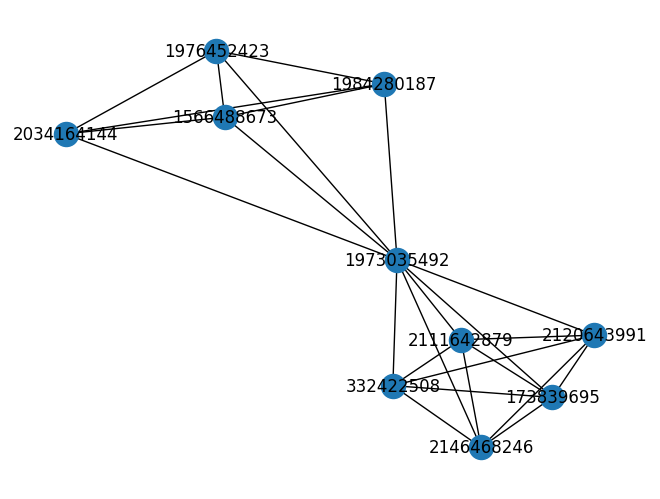

In [37]:
nx.draw(G_collaboration.subgraph(top_N_nodes(degree_collaboration, 10)), with_labels=True)

Let's try with a different centrality measure, the closeness centrality, which could also be a good choice for this problem.

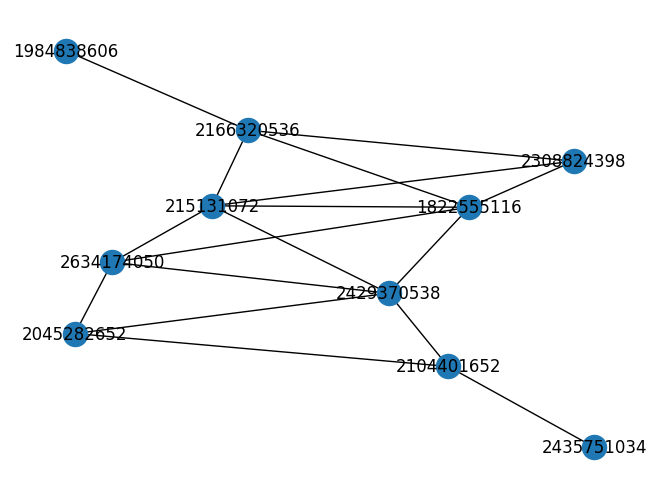

In [38]:
nx.draw(G_collaboration.subgraph(top_N_nodes(closeness_collaboration, 10)), with_labels=True)

The degree centrality seems a better choice for this problem, since from the graph we see it is more likely to find a path between two nodes with high degree centrality as they have more edges.

Next we implement from scratch the Breadth First Search (BFS) algorithm to find the shortest path between two nodes in a graph. The BFS algorithm is an algorithm for traversing graph data structures. It starts at the a node $v$ and explores all of the neighbor nodes at the present depth before moving on to the nodes at the next depth level. The algorithm uses a queue data structure to store intermediate results as it traverses the graph. 

In [39]:
# Breadth-first search algorithm
def bfs(graph, initial_node, end_node):
    
    # Initialize a queue and a set   
    visited = set()
    queue = deque([(initial_node, [])])

    # Iterate through queue
    while queue:
        v, path = queue.popleft()
        visited.add(v)

        # Iterate through neighbors
        for neighbor in graph.neighbors(v):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, path + [v]))

        # Check if we reached the end node
        if v == end_node:
            return path + [v]

Next we implement the function that finds the shortest ordered walk between two nodes in a graph. The top N authors are chosen based on the degree centrality measure, while the sequence of authors is chosen randomly from the top N authors in order to increment the probability of finding a path between the two nodes. 

In [40]:
def shortest_ordered_walk(collaboration_graph, authors_sequence_length, N):
    
    #Filter to only consider the top N authors based on a centrality measure
    f_graph = collaboration_graph.subgraph(top_N_nodes(degree_collaboration, N))
    
    # Generate a random sequence of authors from the filtered graph
    authors_sequence = random.sample(list(f_graph.nodes()), authors_sequence_length)
    initial_node = authors_sequence[0]
    end_node = authors_sequence[-1]
    
    # Initialize the final path with the initial node
    final_path = [initial_node]
    
    # Find the shortest path between the initial and end node
    for i in range(len(authors_sequence) - 1):
        p = bfs(f_graph, authors_sequence[i], authors_sequence[i+1])
        if p:
            final_path += p[1:]
        else:
            print("There is no such path")
            return None
        
    if all([node in final_path for node in authors_sequence]):
        print("There is a valid path")
        print('Top N authors: ', f_graph.nodes())
        print('Authors sequence: ', authors_sequence)
        print('Path: ', final_path)
        return final_path, authors_sequence
    else:
        print("There is no such path")

In [41]:
sow, auth_seq = shortest_ordered_walk(G_collaboration, 5, 10)

There is a valid path
Top N authors:  ['2146468246', '1973035492', '173839695', '1984280187', '2120643991', '2034164144', '1976452423', '1566488673', '332422508', '2111642879']
Authors sequence:  ['2146468246', '2111642879', '173839695', '2034164144', '1976452423']
Path:  ['2146468246', '2111642879', '173839695', '1973035492', '2034164144', '1976452423']


Get the papers that connect the authors in the shortest path.

In [42]:
paper_ids = []
for i in range(len(sow) - 1):
    check_list = [sow[i], sow[i+1]]

    for idx, row in top_10000_data['author_ids'].items():
        if set(check_list).issubset(row):
            paper_ids.append(top_10000_data.iloc[idx].id)
            print('Authors ', check_list, 'collaborated in the paper: "', top_10000_data.iloc[idx].title,'"')
            break
print('\nPaper IDs: ', paper_ids)

Authors  ['2146468246', '2111642879'] collaborated in the paper: " InterPro in 2011: new developments in the family and domain prediction database "
Authors  ['2111642879', '173839695'] collaborated in the paper: " InterPro in 2011: new developments in the family and domain prediction database "
Authors  ['173839695', '1973035492'] collaborated in the paper: " InterPro in 2011: new developments in the family and domain prediction database "
Authors  ['1973035492', '2034164144'] collaborated in the paper: " A promoter-level mammalian expression atlas "
Authors  ['2034164144', '1976452423'] collaborated in the paper: " JASPAR 2016: a major expansion and update of the open-access database of transcription factor binding profiles "

Paper IDs:  [2107644675, 2107644675, 2107644675, 1986223165, 1900337607]


#### ChatGPT implementation

In [43]:
from heapq import heappop, heappush

def dijkstra_shortest_path(graph, initial_node, end_node):
    # Initialize distances and path
    distances = {node: float('inf') for node in graph}
    distances[initial_node] = 0
    previous = {node: None for node in graph}

    priority_queue = [(0, initial_node)]

    while priority_queue:
        current_distance, current_node = heappop(priority_queue)

        if current_node == end_node:
            path = []
            while current_node:
                path.append(current_node)
                current_node = previous[current_node]
            return list(reversed(path)), current_distance

        for neighbor in graph[current_node]:
            weight = 1  # Assuming all edges have the same weight
            distance = current_distance + weight

            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous[neighbor] = current_node
                heappush(priority_queue, (distance, neighbor))

    return [], float('inf')

def shortest_ordered_walk_d(graph, authors_sequence):
    reduced_graph = graph.subgraph(top_N_nodes(degree_collaboration, 10))
    path = []
    for i in range(len(authors_sequence) - 1):
        current_path, distance = dijkstra_shortest_path(reduced_graph, authors_sequence[i], authors_sequence[i+1])
        if not current_path:
            print("There is no such path")
            return None
        path += current_path[:-1]  # Exclude the last node to avoid duplicates

    path.append(authors_sequence[-1])  # Add the last node
    return path


In [44]:
shortest_ordered_walk_d(G_collaboration, ['1973035492', '332422508', '1566488673', '2120643991', '1984280187'])

['1973035492',
 '332422508',
 '1973035492',
 '1566488673',
 '1973035492',
 '2120643991',
 '1973035492',
 '1984280187']

We had to modify the code of the ChatGPT answer in order to make it work, however now it seems to give a correct answer. In particular, the answer is the same that we get from the BFS algorithm, even if the Dijkstra algorithm takes into account the weights of the edges, while the BFS algorithm does not.

### Functionality 4 - Disconnecting Graphs
- Input:

    - The graph data
    - authorA: a paper to which will relate sub-graph G_a
    - authorB: a paper to which will relate sub-graph G_b
    - N : denoting the top N authors that their data should be considered
- Output:

    - The minimum number of edges (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

In [45]:
# Funtion to disconnect a graph
def disconnect_graph(graph, authorA, authorB, N):
    
    # Filter to consider the top N authors based on a centrality measure
    f_graph = graph.subgraph(top_N_nodes(degree_collaboration, N))
    f_graph_copy = f_graph.copy()

    # Initialize lists to store neighbors of each author
    authorA_neighbors = []
    authorB_neighbors = []
    
    while len(f_graph_copy.nodes()) > 2:
        
        # Collect candidate edges for contraction based on edge weights
        candidate_edges = []
        for v in [authorA, authorB]:
            for neighbor in f_graph_copy.neighbors(v):
                # Check if the neighbor is not the other author
                if neighbor not in [authorA, authorB]:
                    # Add the edge to the candidate list
                    candidate_edges.append(((v, neighbor), f_graph_copy[v][neighbor]['weight']))

        # If no valid edges found, break the loop
        if not candidate_edges:
            break

        # Randomly select an edge based on weights
        edges_c, edges_weights = zip(*candidate_edges)
        chosen_edge = random.choices(edges_c, weights=edges_weights)[0]
        v, w = chosen_edge

        # Update neighbors lists
        authorA_neighbors.append(w) if v == authorA else authorB_neighbors.append(w)

        # Contract the chosen edge
        f_graph_copy = nx.contracted_edge(f_graph_copy, chosen_edge, self_loops=False)

    # Create subgraphs based on contracted nodes
    G_sub_authA = nx.subgraph(f_graph, authorA_neighbors + [authorA])
    G_sub_authB = nx.subgraph(f_graph, authorB_neighbors + [authorB])

    # Calculate the number of removed edges
    removed_edges = len(f_graph.edges) - len(G_sub_authA.edges) - len(G_sub_authB.edges)
    return removed_edges, G_sub_authA, G_sub_authB


In [46]:
a, b, c = disconnect_graph(G_collaboration, '1973035492', '1984280187', 15)
a

20

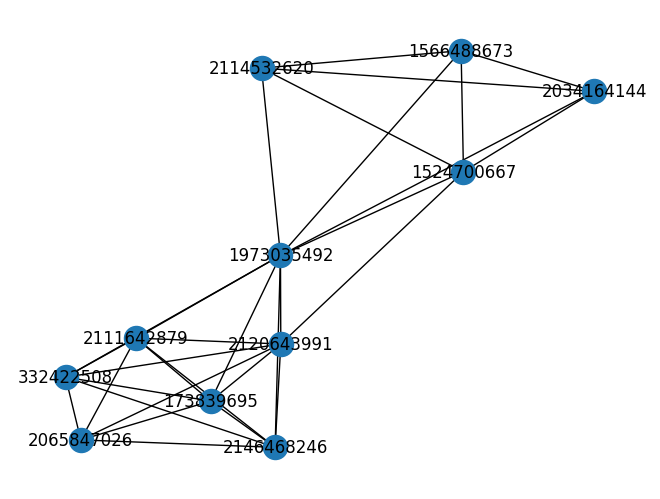

In [47]:
nx.draw(b, with_labels=True)

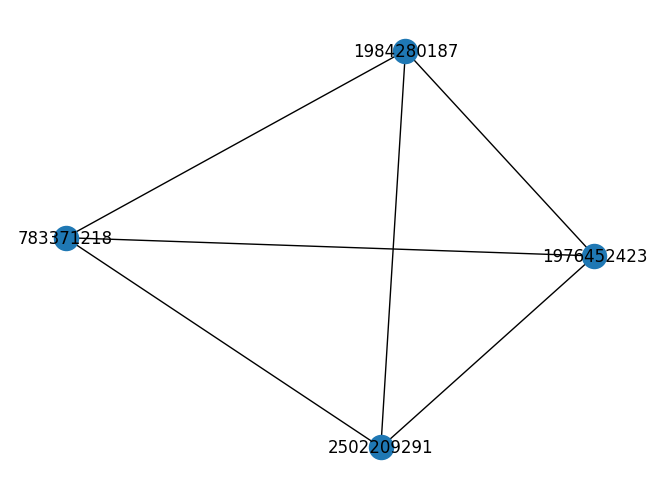

In [48]:
nx.draw(c, with_labels=True)

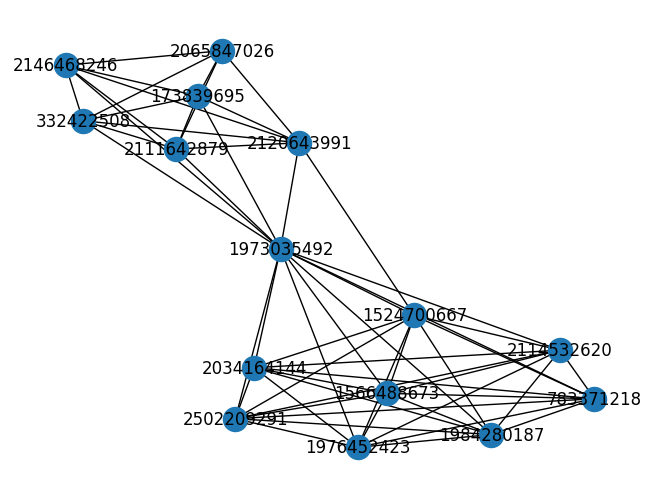

In [49]:
nx.draw(G_collaboration.subgraph(top_N_nodes(degree_collaboration, 15)), with_labels=True)

### Functionality 5 - Extracting Communities
- Input:

    - The graph data
    - N : denoting the top N papers that their data should be considered
    - Paper_1: denoting the name of one of the papers
    - Paper_2: denoting the name of one of the papers

- Output:

    - The minimum number of edges that should be removed to form communities
    - A list of communities, each containing a list of papers that belong to them.
    - Whether the Paper_1 and Paper_2 belongs to the same community.

We implement the algorithm for community detection following the directions proposed in the linked article in the homework text. However, we introduce some modifications to handle our requirements.

**Theory behind the algorithm**:

- **Community**: A community, with respect to graphs, can be defined as a subset of nodes that are densely connected to each other and loosely connected to the nodes in the other communities in the same graph.

- **Girvan-Newman Algorithm for Community Detection**: divisive method for community detection. The communities in a graph are discovered by iteratively removing the edges of the graph, based on the edge betweenness centrality value. The edge with the highest edge betweenness is removed first.

- **Edge betweenness centrality**: measures the number of times an edge lies on the shortest path between pairs of nodes in the network. It identifies edges that serve as critical bridges or bottlenecks for information flow between pairs of nodes.

In [50]:
# Function to find edge with highest betweenness centrality
def edge_to_remove(graph):
        # Compute edge betweenness centrality
        edge_betwenness = nx.edge_betweenness_centrality(graph)
        # Sort the edges according to edge betweenness centrality
        sorted_edge_betwenness = sorted(edge_betwenness.items(), key=lambda x: x[1], reverse=True)
        edge_to_remove = sorted_edge_betwenness[0][0]
        
        return edge_to_remove
        
# Function to extract communities and check if two papers belong to the same community
def extract_communities(graph, N, paper_1, paper_2):
        # Filter to consider the top N authors based on a centrality measure and convert to undirected graph
        f_graph = graph.subgraph(top_N_nodes(nx.degree_centrality(graph), N)).to_undirected()
        
        # Find number of connected components
        num_conn_comps = nx.number_connected_components(f_graph)

        # Initialize number of removed edges
        edges_removed = 0
        
        # Remove edges until the graph is disconnected
        while num_conn_comps == 1:
            # Remove edge with highest betweenness centrality
            f_graph.remove_edge(edge_to_remove(f_graph)[0], edge_to_remove(f_graph)[1])
            edges_removed += 1
            # Update number of connected components and connected components
            num_conn_comps = nx.number_connected_components(f_graph)
            
        # Find communities to which the two papers belong
        paper_1_community = None
        paper_2_community = None
        
        communities = list(nx.connected_components(f_graph))
        for community in communities:
                if paper_1 in community:
                        paper_1_community = community
                if paper_2 in community:
                        paper_2_community = community

        # Check if the two papers belong to the same community
        if paper_1_community == paper_2_community:
                print("The two papers belong to the same community")
        else:
                print("The two papers belong to different communities")
        
        return f_graph, communities, edges_removed

Since applying the algorithm to random nodes would be useless to test how it works, given the graph is already disconnected, we decided to apply it to a subgraph of the original one composed by only strongly connected components.
In a directed graph, strongly connected components represent sets of nodes where every node is reachable from every other node following the direction of edges.

In [51]:
G_citation_strong  = G_citation.subgraph(max(nx.strongly_connected_components(G_citation), key=len))
print(f"Number of nodes in the largest strongly connected component: {len(G_citation_strong.nodes())}")

Number of nodes in the largest strongly connected component: 56


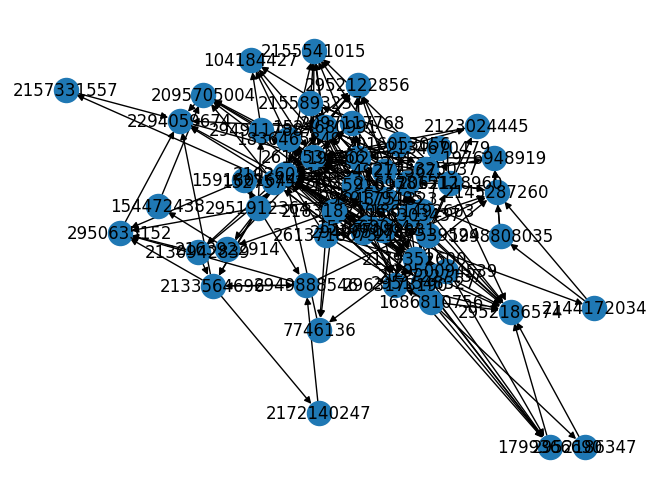

In [52]:
nx.draw(G_citation_strong, with_labels=True)

In [53]:
N = 40
paper_1, paper_2 = random.sample(list(G_citation_strong.subgraph(top_N_nodes(nx.degree_centrality(G_citation_strong), N))), 2)
print(f"Paper 1: {paper_1}")
print(f"Paper 2: {paper_2}")
new_graph, comms, edges_removed = extract_communities(G_citation_strong.copy(), N, paper_1, paper_2)
print(f"Number of edges removed: {edges_removed}")

Paper 1: 2949888546
Paper 2: 1903029394
The two papers belong to different communities
Number of edges removed: 13


In [54]:
communities = []
for i in comms:
    communities.append(list(i))
len(communities)

2

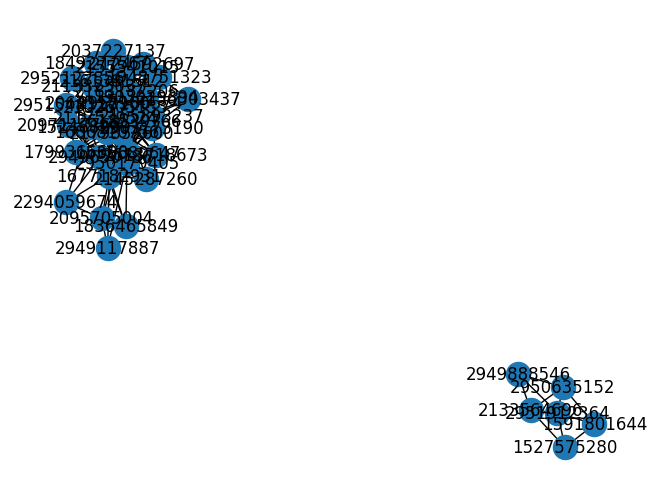

In [55]:
nx.draw(new_graph, with_labels=True)

## 2.2 Frontend implementation

### Visualization 1 - Visualize graph features

- A table containing the following general information about the graph:
    - Number of nodes in the graph
    - Number of the edges in the graph
    - Density of the graph
    - Average degree of the graph
    - Whether the network is sparse or dense
- A table that lists the graph's hubs
- A plot depicting the distribution of the citations received by papers (Citation graph)
- A plot depicting the distribution of the given citations by papers (Citation graph)
- A plot depicting the number of collaborations of the author (Collaboration graph)


In [56]:
# Define the columns and create a dataframe
columns = ['Number of Nodes', 'Number of Edges', 'Graph Density', 'Average Degree', 'Graph Density Classification']
table_1= pd.DataFrame(columns=columns)

# Update the dataframe with the results of the reports
table_1.loc['Citation Graph'] = [report['Number of Nodes'], report['Number of Edges'], report['Graph Density'], report['Average Degree'], report['Graph Density Classification']]
table_1.loc['Collaboration Graph'] = [report_collaboration['Number of Nodes'], report_collaboration['Number of Edges'], report_collaboration['Graph Density'], report_collaboration['Average Degree'], report_collaboration['Graph Density Classification']]
table_1

,Number of Nodes,Number of Edges,Graph Density,Average Degree,Graph Density Classification
Citation Graph,100853,187843,0.000018,0.536900,sparse
Collaboration Graph,21235,136477,0.000605,12.853968,sparse


In [57]:
# Create a table for the hubs
table_hubs = pd.DataFrame({'Citaton Graph Hubs': report['Graph Hubs']})
table_hubs = table_hubs.merge(pd.DataFrame({'Collaboration Graph Hubs': report_collaboration['Graph Hubs']}),how='outer', left_index=True, right_index=True)
table_hubs

,Citaton Graph Hubs,Collaboration Graph Hubs
0,1699105,1566488673
1,1604454960,1976452423
2,1660562555,2034164144
3,2109394932,1984280187
4,2151511199,2229209549
...,...,...
5459,2225156818,NaN
5460,2284219800,NaN
5461,2519706319,NaN
5462,340244495,NaN


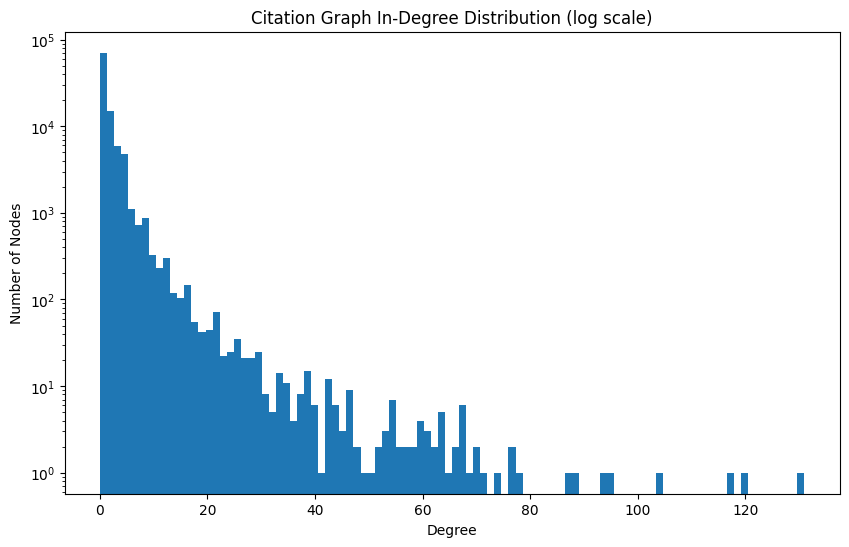

In [60]:
# Plot the distributions of the citations received by the top 10000 papers
plt.figure(figsize=(10, 6))
plt.title('Citation Graph In-Degree Distribution (log scale)')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.hist(report['Graph Degree Distribution'][0], bins=100)
plt.yscale('log')
plt.show()


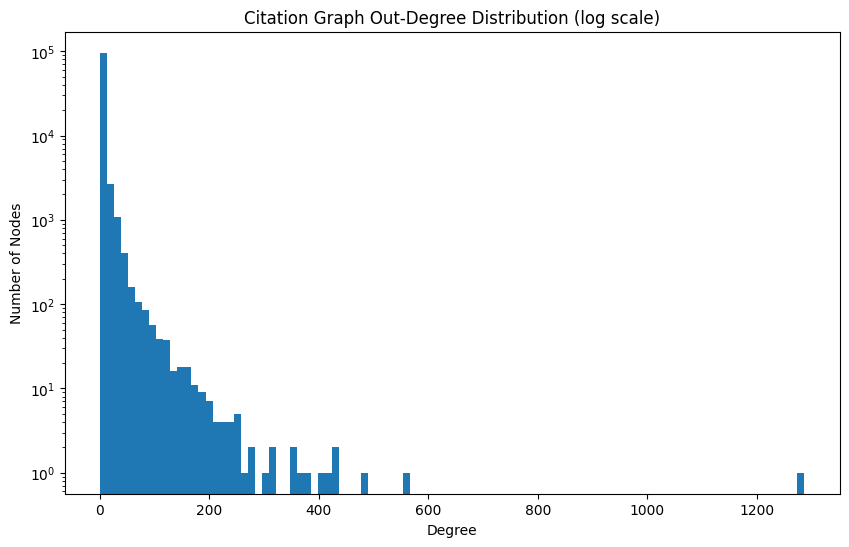

In [66]:
# Plot the distributions of the citations given by the top 10000 papers
plt.figure(figsize=(10, 6))
plt.title('Citation Graph Out-Degree Distribution (log scale)')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.hist(report['Graph Degree Distribution'][1], bins=100)
plt.yscale('log')
plt.show()

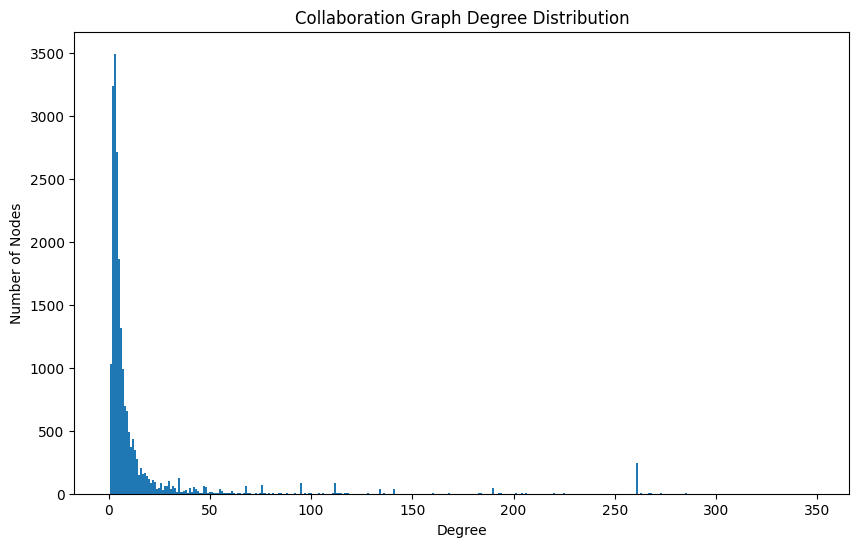

In [63]:
# Plot the distributions of the collaboration of the authors
plt.figure(figsize=(10, 6))
plt.title('Collaboration Graph Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
x_values = range(1, len(report_collaboration['Graph Degree Distribution']) + 1)
plt.bar(x_values, report_collaboration['Graph Degree Distribution'], width=1.0)
plt.show()

### Visualization 2 - Visualize the node's contribution
A table containing the node's centrality value based on the four centrality measurements

In [67]:
# Create a table for the nodes contribution
columns = ['Node', 'Betweenness Centrality', 'Pagerank Centrality', 'Closeness Centrality', 'Degree Centrality']
table_2 = pd.DataFrame(columns=columns, index=['Citation Graph', 'Collaboration Graph'])

# Update the dataframe with the results of the reports
table_2.loc['Citation Graph'] = [report_nodes_citation['Node'], report_nodes_citation['Betweenness Centrality'], report_nodes_citation['Pagerank Centrality'], report_nodes_citation['Closeness Centrality'], report_nodes_citation['Degree Centrality']]
table_2.loc['Collaboration Graph'] = [report_nodes_collaboration['Node'], report_nodes_collaboration['Betweenness Centrality'], report_nodes_collaboration['Pagerank Centrality'], report_nodes_collaboration['Closeness Centrality'], report_nodes_collaboration['Degree Centrality']]
table_2

,Node,Betweenness Centrality,Pagerank Centrality,Closeness Centrality,Degree Centrality
Citation Graph,2041404167,0.0,0.000104,0.011729,0.000942
Collaboration Graph,2058584252,0.003166,0.000168,0.063954,0.001366


### Visualization 3 - Visualize the shortest-ordered route
- Print the papers needed to be crossed in the shortest walk in order
- Plot the graph and identify the nodes and edges that appear in the shortest walk

In [482]:
# Choose the N and authors_sequence_length parameters
N = 20
authors_sequence_length = 5
# Run the shortest ordered walk algorithm
sow, auth_seq = shortest_ordered_walk(G_collaboration, authors_sequence_length, N)

There is a valid path
Top N authors:  ['783371218', '2120643991', '2502209291', '2130160582', '1978529654', '2114532620', '1524700667', '1973035492', '173839695', '2111642879', '1984280187', '1566488673', '2126370775', '2240988444', '2034164144', '2065847026', '2146468246', '338444495', '332422508', '1976452423']
Authors sequence:  ['1566488673', '173839695', '2502209291', '2126370775', '338444495']
Path:  ['1566488673', '1973035492', '173839695', '1973035492', '2502209291', '2126370775', '338444495']


In [504]:
# Initialize two lists to store the paper ids and titles
paper_ids = []
paper_titles = []

# Iterate through the path
for i in range(len(sow) - 1):
    # Create a list with the two authors
    check_list = [sow[i], sow[i+1]]
    
    # Iterate through the author ids
    for idx, row in top_10000_data['author_ids'].items():
        # Check if the two authors collaborated in a paper
        if set(check_list).issubset(row):
            # Append the paper id and title to the lists
            paper_ids.append(top_10000_data.iloc[idx].id)
            paper_titles.append(top_10000_data.iloc[idx].title)
        
            print('Authors ', check_list, 'collaborated in the paper: "', top_10000_data.iloc[idx].title,'"')
            break

Authors  ['1566488673', '1973035492'] collaborated in the paper: " A promoter-level mammalian expression atlas "
Authors  ['1973035492', '173839695'] collaborated in the paper: " InterPro in 2011: new developments in the family and domain prediction database "
Authors  ['173839695', '1973035492'] collaborated in the paper: " InterPro in 2011: new developments in the family and domain prediction database "
Authors  ['1973035492', '2502209291'] collaborated in the paper: " A promoter-level mammalian expression atlas "
Authors  ['2502209291', '2126370775'] collaborated in the paper: " A promoter-level mammalian expression atlas "
Authors  ['2126370775', '338444495'] collaborated in the paper: " A promoter-level mammalian expression atlas "


In [517]:
print('Papers to be crossed in shortest ordered walk: ', '\n')
# Iterate through the paper titles and ids
for title, id in zip(paper_titles, paper_ids):
    print('Title: "', title,'" , ID:', id)

Papers to be crossed in shortest ordered walk:  

Title: " A promoter-level mammalian expression atlas " , ID: 1986223165
Title: " InterPro in 2011: new developments in the family and domain prediction database " , ID: 2107644675
Title: " InterPro in 2011: new developments in the family and domain prediction database " , ID: 2107644675
Title: " A promoter-level mammalian expression atlas " , ID: 1986223165
Title: " A promoter-level mammalian expression atlas " , ID: 1986223165
Title: " A promoter-level mammalian expression atlas " , ID: 1986223165


In [484]:
# Create a list of edges
edges = [(sow[i], sow[i+1]) for i in range(len(sow) - 1)]  
# Create a list that keeps count of when each edge is crossed 
w = [[str(i+1)] for i in range(len(sow) - 1)]

# Create a dictionary with the edges as keys and the order in which each edge is crossed as values
edge_labels_dict = {edge: label for edge, label in zip(edges, w)}
# Create a list of edges that are crossed more than once
dupli = [e for e in edge_labels_dict.keys() if e[::-1] in edge_labels_dict.keys()]

# Iterate through the dictionary of edges
for e in edge_labels_dict.keys():
    # Check if the edge is crossed more than once
    if e in dupli:
        # Append the order in which the edge is crossed to the list
        edge_labels_dict[e].append(edge_labels_dict[e[::-1]][0])
    # Join the list of orders in which the edge is crossed
    edge_labels_dict[e] = ' - '.join(edge_labels_dict[e])   

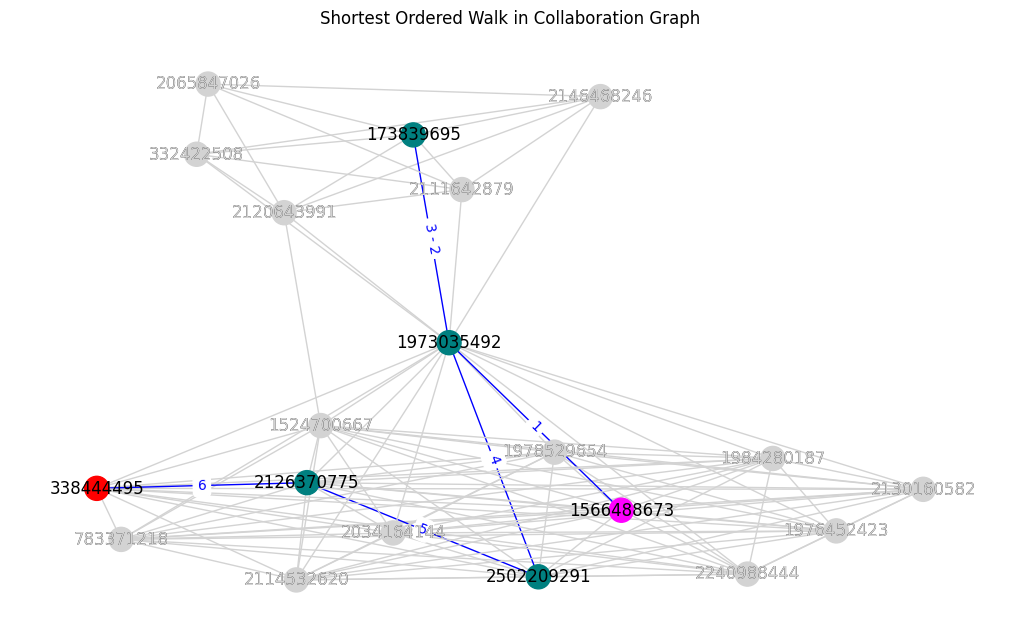

In [592]:
# Create a graph to visualize the shortest ordered walk
plt.figure(figsize=(10, 6))
# Create a subgraph with the top N nodes
subgraph = G_collaboration.subgraph(top_N_nodes(degree_collaboration, N))
# Create a list of node colors
node_colors = ['magenta' if node == auth_seq[0] else 'red' if node == auth_seq[-1] else 'teal' if node in sow else 'lightgray' for node in subgraph.nodes()]
# Create a list of edge colors
edge_colors = ['blue' if edge in edges or edge[::-1] in edges else 'lightgray' for edge in subgraph.edges()]
# Define the layout of the graph
pos = nx.spring_layout(subgraph)
# Draw the graph
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors)
# Draw the edge labels
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels_dict, font_color='blue')
# Draw the node labels for the nodes that are not in the shortest ordered walk
nx.draw_networkx_labels(subgraph, pos=pos, labels={node: str(node) for node in subgraph.nodes() if node not in sow}, font_color='lightgray')

plt.title('Shortest Ordered Walk in Collaboration Graph')
plt.show()

### Visualization 4 - Visualize the disconnected graph
- Print the number of the links that should be disconnected
- Plot the original graph
- Plot the graph after removing the links and identify the two nodes

In [570]:
# Define the function parameters
N = 20
authorA = '1973035492'
authorB = '1984280187'

# Find the number of edges to remove and the two subgraphs
num_of_edges_to_remove, subgraphA, subgraphB = disconnect_graph(G_collaboration, authorA, authorB, N)
print('Number of links that should be disconnected: ', num_of_edges_to_remove)

Number of links that should be disconnected:  49


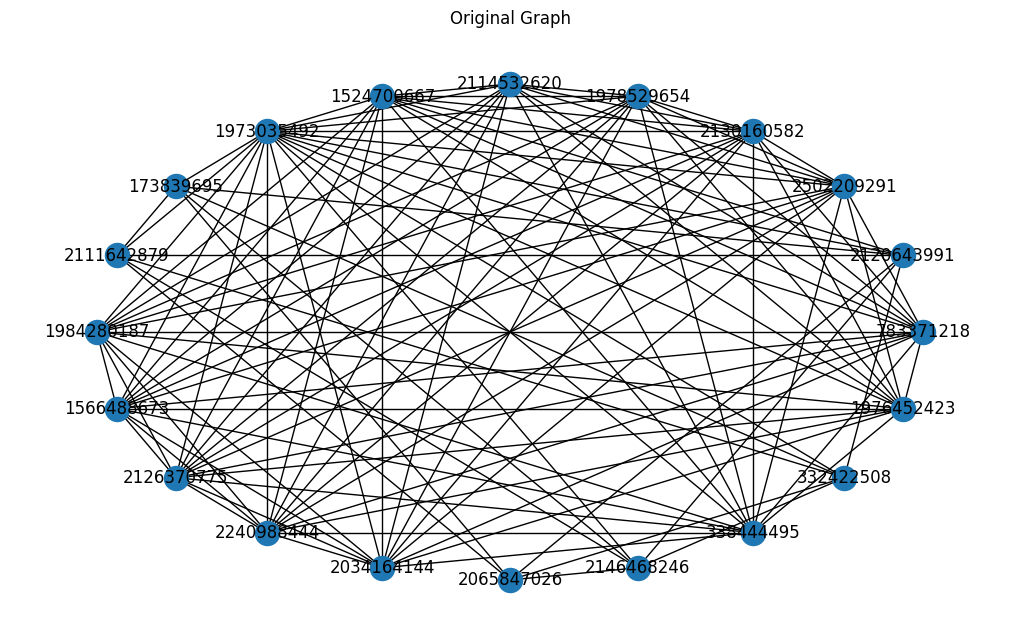

In [684]:
plt.figure(figsize=(10, 6))

# Define original graph
original_graph = G_collaboration.subgraph(top_N_nodes(degree_collaboration, N))
# Specify layout
pos = nx.circular_layout(original_graph)
# Draw the graph
nx.draw(original_graph,pos, with_labels= True)

plt.title('Original Graph')
plt.show()  

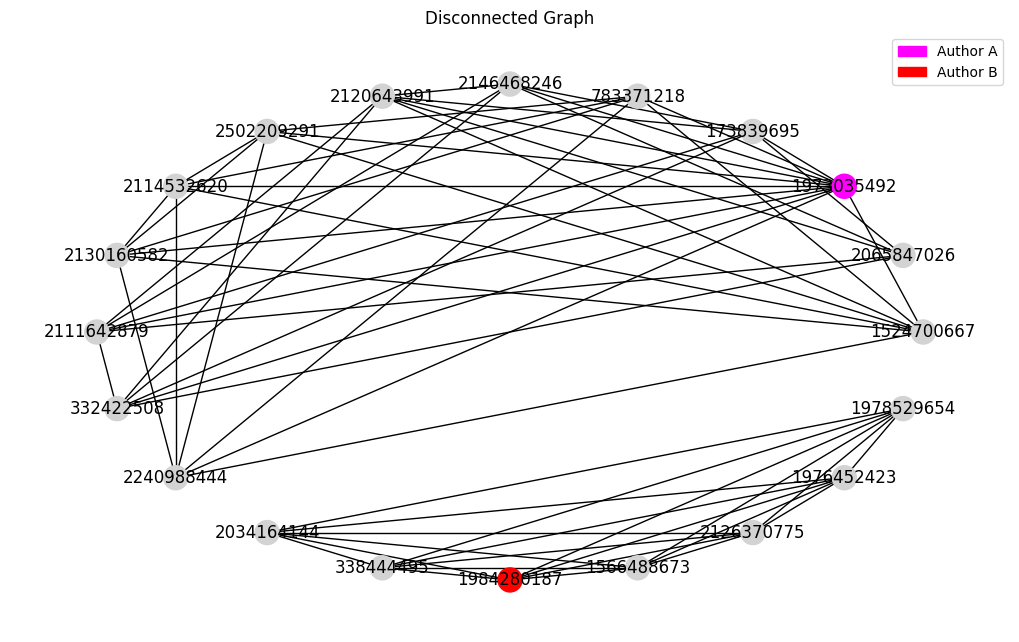

In [588]:
plt.figure(figsize=(10, 6))

# Combine the two subgraphs
combined_graph = nx.compose(subgraphA, subgraphB)
# Specify the layout
pos = nx.circular_layout(combined_graph)
# Specify the node colors
node_colors = ['magenta' if node == authorA else 'red' if node == authorB else 'lightgray' for node in combined_graph.nodes()]

# Draw the combined graph
nx.draw(combined_graph, pos,  node_color=node_colors, with_labels=True)

# Create a legend for the node colors
magenta_patch = mpatches.Patch(color='magenta', label='Author A')
red_patch = mpatches.Patch(color='red', label='Author B')

# Add legend to the plot
plt.legend(handles=[magenta_patch, red_patch])

plt.title('Disconnected Graph')
plt.show()

### Visualization 5 - Visualize the communities
- Print the number of links that should be removed to have the communities
- A table depicting the communities and the papers that belong to each community
- Plot the original graph
- Plot the graph showing the communities in the network
- Plot the final graph and identify the community/communities of Paper_1 and Paper_2

In [828]:
# Define the function parameters
N = 40
original_graph = G_citation_strong.subgraph(top_N_nodes(nx.degree_centrality(G_citation_strong), N))
paper_1, paper_2 = random.sample(list(original_graph), 2)
print(f"Paper 1: {paper_1}")
print(f"Paper 2: {paper_2}")

# Find the number of edges to remove and the two subgraphs
new_graph, comms, edges_removed = extract_communities(G_citation_strong.copy(), N, paper_1, paper_2)

Paper 1: 2124592697
Paper 2: 2133564696
The two papers belong to different communities


In [829]:
print('Number of edges to remove to have the communities: ', edges_removed)

Number of edges to remove to have the communities:  13


In [830]:
# Create a table depicting the communities and the papers belonging to each community

# Create a dictionary to store the communities
communities = {}
for i in range(len(comms)):
    communities[i+1] = list(comms[i])

# Fill the dictionary with nan values for the communities with less papers
for key, val in communities.items():
    if len(val) < max([len(v) for v in communities.values()]):
        communities[key] = val + [np.nan] * (max([len(v) for v in communities.values()]) - len(val))

# Create a dataframe from the dictionary
df_communities = pd.DataFrame(communities)
df_communities.head()

,1,2
0,2037227137,2.949889e+09
1,1686810756,2.951912e+09
2,2161381512,1.591802e+09
3,2613718673,2.950635e+09
4,1903029394,1.527575e+09


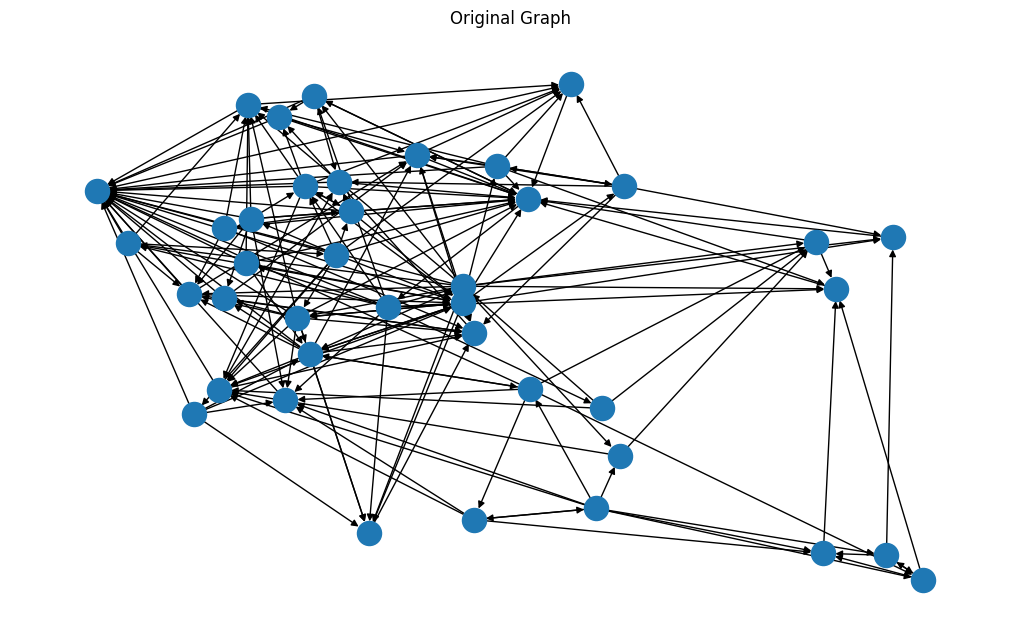

In [831]:
# Plot the original graph
plt.figure(figsize=(10, 6))

# Specify the layout
pos = nx.spring_layout(original_graph)
nx.draw(original_graph, pos)

plt.title('Original Graph')
plt.show()

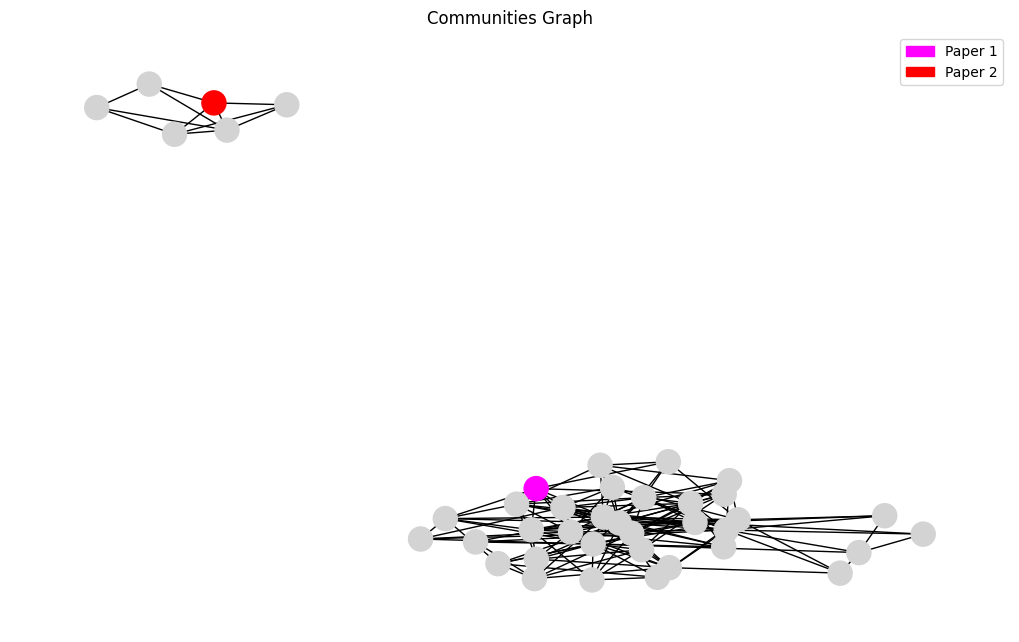

In [832]:
# Plot the communities graph

plt.figure(figsize=(10, 6))

# Specify the layout
pos = nx.spring_layout(new_graph)
# Specify the node colors
node_colors = ['magenta' if node == paper_1 else 'red' if node == paper_2 else 'lightgray' for node in new_graph.nodes()]
nx.draw(new_graph, pos, node_color=node_colors)

# Create a legend for the node colors
magenta_patch = mpatches.Patch(color='magenta', label='Paper 1')
red_patch = mpatches.Patch(color='red', label='Paper 2')
plt.legend(handles=[magenta_patch, red_patch])

plt.title('Communities Graph')
plt.show()

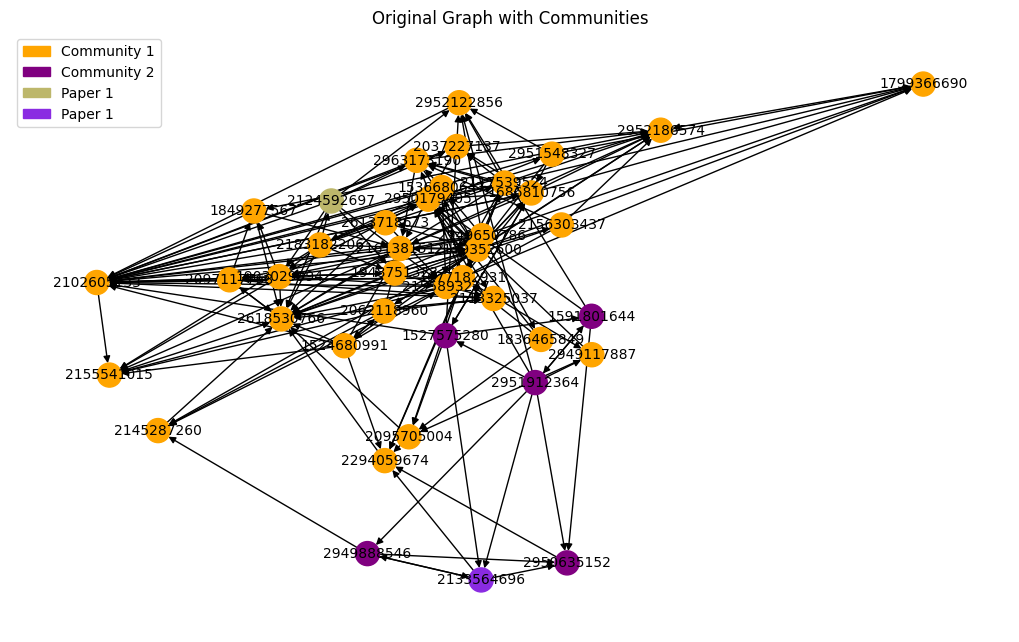

In [837]:
# Plot the original graph with communities

plt.figure(figsize=(10, 6))
# Specify the layout
pos = nx.spring_layout(original_graph)

# Specify the node colors
node_colors = ['darkkhaki' if (node == paper_1 and node in communities[1])
               else 'yellow' if (node == paper_2 and node in communities[1])
               else 'magenta' if (node == paper_1 and node in communities[2])
               else 'blueviolet' if (node == paper_2 and node in communities[2])
               else 'orange' if node in communities[1] else 'purple' if node in communities[2] 
               else 'lightgray' for node in original_graph.nodes()]

# Draw the graph
nx.draw(original_graph, pos, node_color=node_colors, with_labels=True, font_size=10)

# Create a legend for the node colors
orange_patch = mpatches.Patch(color='orange', label='Community 1')
purple_patch = mpatches.Patch(color='purple', label='Community 2')
if paper_1 in communities[1]:
    p1_patch = mpatches.Patch(color='darkkhaki', label='Paper 1')
else:
    p1_patch = mpatches.Patch(color='magenta', label='Paper 2')
if paper_2 in communities[1]:
    p2_patch = mpatches.Patch(color='yellow', label='Paper 2')
else:
    p2_patch = mpatches.Patch(color='blueviolet', label='Paper 1')
plt.legend(handles=[orange_patch, purple_patch, p1_patch, p2_patch])

plt.title('Original Graph with Communities')
plt.show()

# 3. Bonus Question

In [14]:
#adjacency_list = {node: list(G_citation.neighbors(node)) for node in G_citation.nodes()}
adjacency_matrix = nx.adjacency_matrix(G_citation)

In [15]:
adjacency_matrix[0:5, 0:5].todense()

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int32)

In [16]:
N = adjacency_matrix.shape[0]
print(f"Number of nodes: {N}")

Number of nodes: 100853


In [17]:
q = np.ones(N)/N
q[:5]

array([9.91542145e-06, 9.91542145e-06, 9.91542145e-06, 9.91542145e-06,
       9.91542145e-06])

In [27]:
def split_sparse_matrix(matrix, k):
    num_cols = matrix.shape[1]
    split_size = num_cols // k  # Calculate the size of each split

    vertical_splits = []

    # Splitting the matrix into k vertical segments
    for i in range(k):
        start_col = i * split_size
        end_col = (i + 1) * split_size if i < k - 1 else num_cols
        split = matrix[:, start_col:end_col]  # Slicing the sparse matrix
        vertical_splits.append(split)

    return vertical_splits

k = 1000
M_splits = split_sparse_matrix(adjacency_matrix, k)

In [28]:
M_splits[0].todense().shape

(100853, 100)

In [29]:
def break_vector(q, k):
    num_elements = len(q)
    split_size = num_elements // k  # Calculate the size of each split

    q_splits = []

    # Splitting the vector into k segments
    for i in range(k):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < k - 1 else num_elements
        split = q[start_idx:end_idx]
        q_splits.append(split)

    return q_splits

k = 1000
q_splits = break_vector(q, k)
q_splits[0].shape

(100,)

In [30]:
M_splits[0].todense()[1]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [39]:
def mapper(j, q, M):
    intermediate_results = []
    for j_prime in range(len(M.todense())):
        intermediate_results.append(M.todense()[j_prime][j] * q[j])
    return list(enumerate(intermediate_results))

mapped_0 = mapper(0, q_splits[0], M_splits[0])
mapped_1 = mapper(1, q_splits[0], M_splits[0])


In [45]:
len(mapped_0)

100853

In [36]:
def reducer(intermediate_values):
    results = [0] * n
    for j_prime, value in intermediate_values:
        results[j_prime] += value

    new_q = [value * beta + (1 - beta) / n for value in results]
    return new_q

In [40]:
beta = 0.85
n = len(q)

inter = mapped_0 + mapped_1

new_q = reducer(inter)

new_q[:5]

[1.4873132182483418e-06,
 1.4873132182483418e-06,
 1.4873132182483418e-06,
 1.4873132182483418e-06,
 1.4873132182483418e-06]

In [41]:
len(new_q)

100853

In [43]:
reducer(mapped_1)[:5]

[1.4873132182483418e-06,
 1.4873132182483418e-06,
 1.4873132182483418e-06,
 1.4873132182483418e-06,
 1.4873132182483418e-06]